# Demo Notebook
This notebook demonstrates the use of the `PyOCN` library to create and optimize Optimal Channel Networks (OCNs) on a grid. It includes functions for generating random OCNs, optimizing them using simulated annealing, and visualizing the results.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import PyOCN as po

## Simple OCN Example
Initialize an OCN from one of the built-in network types with default parameters.

In [2]:
ocn = po.OCN.from_net_type(
    net_type="V",
    dims=(64, 64),
    random_state=8472,
)

# optimize the OCN using simulated annealing and default parameters
ocn.fit(pbar=True)
history = ocn.history

OCN Fit: 100%|██████████| 164k/164k [00:00<00:00, 325kit/s, E=1.2e+04, T/E=00.00%, ΔE/E=-00.03%] 


In [3]:
G = ocn.to_digraph()
np.mean(list(nx.get_node_attributes(G, "drained_area").values()))

np.float64(48.222412109375)

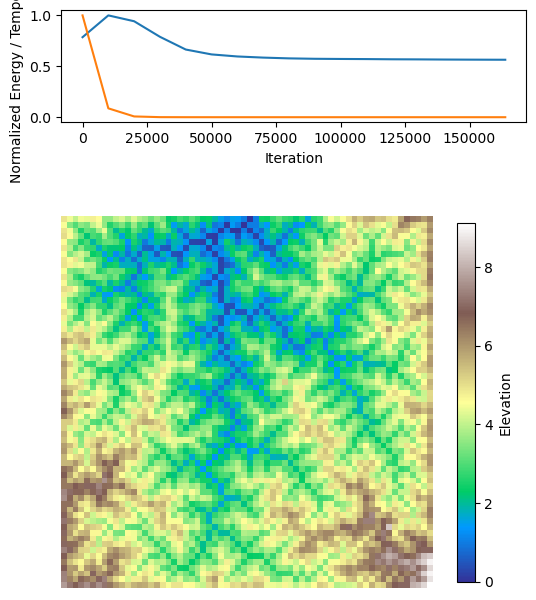

In [6]:
fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(history[:, 0], history[:, 1] / np.max(history[:, 1]))
axs[0].plot(history[:, 0], history[:, 2] / np.max(history[:, 2]))
axs[0].set_ylabel("Normalized Energy / Temperature")
axs[0].set_xlabel("Iteration")

_, im = po.plotting.plot_ocn_raster(ocn, attribute="elevation", ax=axs[1])
fig.colorbar(im, ax=axs[1], shrink=0.8, label="Elevation")
axs[1].set_axis_off()

## OCN from a custom graph
You can also create an OCN from a custom directed graph using NetworkX.

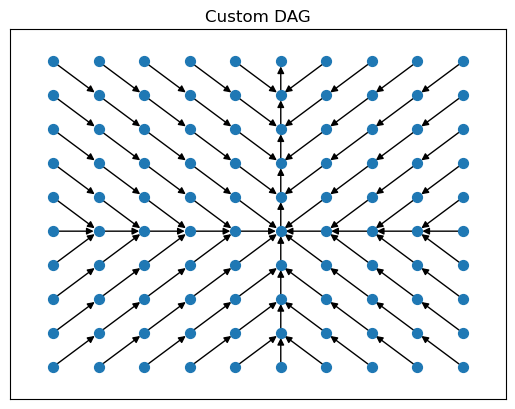

In [8]:
from itertools import product

def cross_center_root(m, n):
    dag = nx.DiGraph()
    halfway_r = n // 2
    halfway_u = m // 2
    for i, (r, c) in enumerate(product(range(m), range(n))):
        dag.add_node(i, pos=(r, c))
        
    for i, (r, c) in enumerate(product(range(m), range(n))):
        # ul quadrant
        if r > halfway_u and c < halfway_r:
            dag.add_edge(i, i - n + 1)
        # ur quadrant
        elif r > halfway_u and c > halfway_r:
            dag.add_edge(i, i - n - 1)
        # ll quadrant
        elif r < halfway_u and c < halfway_r:
            dag.add_edge(i, i + n + 1)
        # lr quadrant
        elif r < halfway_u and c > halfway_r:
            dag.add_edge(i, i + n - 1)
        # middle column
        elif c == halfway_r:
            if r > 0:
                dag.add_edge(i, i - n)
        # middle row
        else:
            if c > halfway_r:
                dag.add_edge(i, i - 1)
            elif c < halfway_r:
                dag.add_edge(i, i + 1)
    return dag

_, ax = po.plotting.plot_positional_digraph(cross_center_root(10, 10), node_size=50, arrowsize=10, with_labels=False)
ax.set_title("Custom DAG");


In [9]:
m, n = 100, 100
ocn = po.OCN.from_digraph(
    dag=cross_center_root(m, n),
    random_state=4000,
)

ocn.fit(pbar=True)
history = ocn.history

OCN Fit: 100%|██████████| 400k/400k [00:02<00:00, 151kit/s, E=3.1e+04, T/E=00.00%, ΔE/E=-00.03%]  


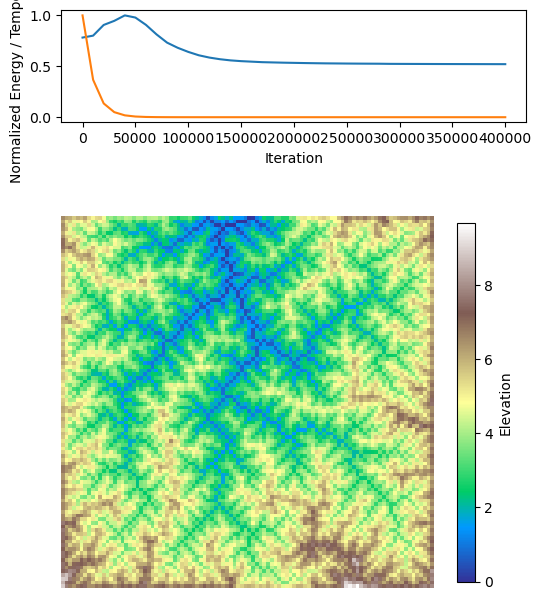

In [11]:
fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(history[:, 0], history[:, 1] / np.max(history[:, 1]))
axs[0].plot(history[:, 0], history[:, 2] / np.max(history[:, 2]))
axs[0].set_ylabel("Normalized Energy / Temperature")
axs[0].set_xlabel("Iteration")

norm = mpl.colors.PowerNorm(gamma=0.5)
_, im = po.plotting.plot_ocn_raster(ocn, ax=axs[1])
fig.colorbar(im, ax=axs[1], shrink=0.8, label="Elevation")
axs[1].set_axis_off()

## Modifying OCN parameters
The main parameters for the OCN optimization are:
* `gamma`: exponent for the energy functional. Controls the dendricity of the network.
* `cooling_rate`: controls the rate of temperature decrease during simulated annealing. A lower value means slower cooling and a less stable configuration.
* `constant_phase`: number of iterations to run at constant temperature before cooling. Longer constant phases allow for more exploration of the configuration space.

Below, we use the custom dag from above and fit the model using different parameter sets.

In [12]:
def ocn_with_params(gamma, constant_phase, cooling_rate, n_iterations, dag):
    ocn = po.OCN.from_digraph(
        dag=dag,
        gamma=gamma,
        random_state=4001,
    )
    ocn.fit(
        cooling_rate=cooling_rate,
        constant_phase=constant_phase,
        n_iterations=n_iterations,
        pbar=True,
        max_iterations_per_loop=1e4,
    )
    history = ocn.history
    return ocn, history

m, n  = 100, 100
dag = cross_center_root(m, n)


OCN Fit: 100%|██████████| 500k/500k [00:04<00:00, 113kit/s, E=3.1e+05, T/E=00.00%, ΔE/E=-00.42%]  


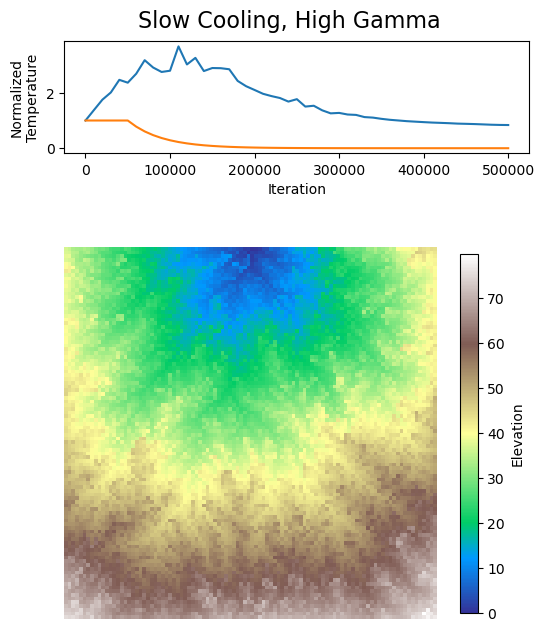

In [16]:
# slow cooling, high gamma
constant_phase = 0.1
cooling_rate = 0.25
n_iterations = m*n*50
gamma = 0.9

ocn, history = ocn_with_params(
    gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(history[:, 0], history[:, 1] / history[0, 1])
axs[0].plot(history[:, 0], history[:, 2] / history[0, 2])
axs[0].set_ylabel("Normalized\nTemperature")
axs[0].set_xlabel("Iteration")

_, im = po.plotting.plot_ocn_raster(ocn, ax=axs[1])
fig.colorbar(im, ax=axs[1], shrink=0.8, label="Elevation")
axs[1].set_axis_off()
fig.suptitle("Slow Cooling, High Gamma", y=0.92, fontsize=16);

OCN Fit: 100%|██████████| 2.00M/2.00M [00:12<00:00, 158kit/s, E=1.3e+04, T/E=00.00%, ΔE/E=+00.00%] 


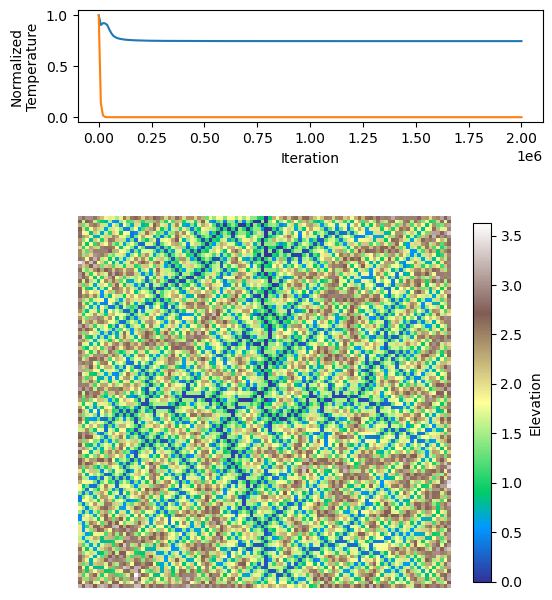

In [ ]:
# fast cooling, low gamma
constant_phase = 0.0
cooling_rate = 2
n_iterations = m*n*200
gamma = 0.2

ocn, history = ocn_with_params(
    gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(history[:, 0], history[:, 1] / history[0, 1])
axs[0].plot(history[:, 0], history[:, 2] / history[0, 2])
axs[0].set_ylabel("Normalized\nTemperature")
axs[0].set_xlabel("Iteration")

_, im = po.plotting.plot_ocn_raster(ocn, ax=axs[1])
fig.colorbar(im, ax=axs[1], shrink=0.8, label="Elevation")
axs[1].set_axis_off()
fig.suptitle("Fast Cooling, Low Gamma", y=0.92, fontsize=16);

## Intermediate Grid States
You can export the intermediate grid states during optimization to analyze the optimization process. This is best done with xarray. You can request the number of grids to be saved with the `array_reports` parameter, but this is only an approximation: the actual number of saved grids depends on the number of "chunks" the optimization is divided into, which you can set explicitly using the `max_iterations_per_loop` parameter. The actual number of saved grids will be a multiple of `n_iterations // max_iterations_per_loop`, plus 1 (the starting state).

In [17]:
import xarray as xr  # done internally usually, but we include it here to document it explicitly
ocn = po.OCN.from_net_type(net_type="E", dims=(100, 100), random_state=8471, gamma=0.5)
ds = ocn.fit(pbar=True, array_reports=5, cooling_rate=0.3)
history = ocn.history
ds

OCN Fit: 100%|██████████| 400k/400k [00:02<00:00, 157kit/s, E=2.4e+04, T/E=00.00%, ΔE/E=-01.20%] 


<xarray.Dataset> Size: 1MB
Dimensions:    (iteration: 6, y: 100, x: 100)
Coordinates:
  * iteration  (iteration) int64 48B 0 80000 160000 240000 320000 400000
  * y          (y) float64 800B 0.0 1.0 2.0 3.0 4.0 ... 95.0 96.0 97.0 98.0 99.0
  * x          (x) float64 800B 0.0 1.0 2.0 3.0 4.0 ... 95.0 96.0 97.0 98.0 99.0
Data variables:
    energy     (iteration, y, x) float64 480kB 239.0 232.0 225.0 ... 1.0 1.0
    area       (iteration, y, x) float64 480kB 50.0 49.0 48.0 ... 2.0 1.0 1.0
    elevation  (iteration, y, x) float64 480kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  OCN fit result arrays
    resolution:   1.0
    gamma:        0.5
    rng:          48010734430618196269203493643391495022
    wrap:         False

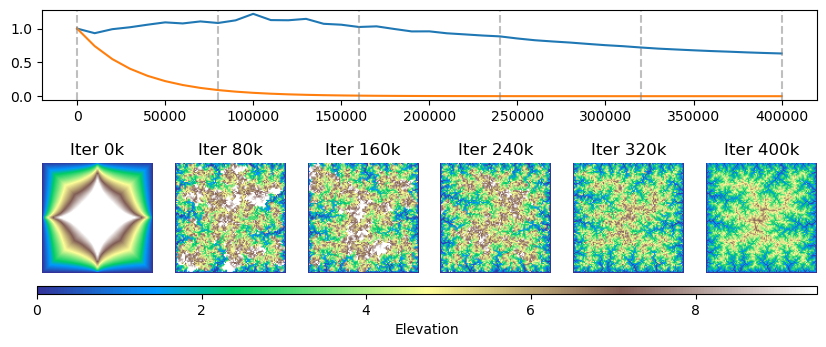

In [51]:
mosaic = """
    AAAAAA
    BCDEFG
    BCDEFG
"""
fig, axs = plt.subplot_mosaic(mosaic, figsize=(10, 4))

t_ax = axs['A']
t_ax.plot(history[:, 0], history[:, 1] / history[0, 1])
t_ax.plot(history[:, 0], history[:, 2] / history[0, 2])

grid_axs = [axs[k] for k in 'BCDEFG']
norm = mpl.colors.Normalize(vmin=0, vmax=ds.elevation.quantile(0.95))
for i, grid_ax in zip(ds.iteration, grid_axs):
    im = grid_ax.imshow(ds.elevation.sel(iteration=i), norm=norm, cmap="terrain")
    grid_ax.set_axis_off()
    grid_ax.set_title(f"Iter {i.item()/1000:.0f}k")
    t_ax.axvline(i, color='gray', linestyle='--', alpha=0.5)

cax = fig.add_axes([0.12, 0.17, 0.78, 0.02])
cbar = fig.colorbar(
    im,
    cax=cax,
    orientation="horizontal",
    fraction=1.0
)
cbar.set_label("Elevation")

## Exporting to GeoTIFF
You can export the OCN to a GeoTIFF file using the `to_gtiff` method. This exports the OCN using the spatial resolution of the grid, which is set at initialization. Band 1 is energy, band 2 is drained area, and band 3 is elevation. Choose a projected coordinate reference system (CRS) for accurate spatial representation before exporting to GTIFF. This ensures that the spatial resolution is meaningful (e.g., in meters) and that the elevation values are computed correctly. You may reproject the raster later if needed.

OCN Fit: 100%|██████████| 400k/400k [00:04<00:00, 99.5kit/s, E=3.4e+05, T/E=00.00%, ΔE/E=-01.00%] 


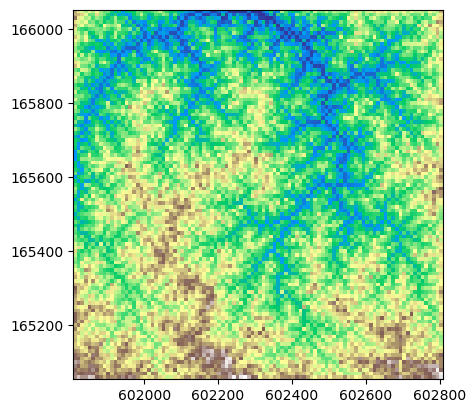

In [ ]:
import rasterio as rio
from rasterio import plot as rioplot

ocn = po.OCN.from_net_type(net_type="V", dims=(100, 100), random_state=8469, gamma=0.5, resolution=10)
ocn.fit(pbar=True, cooling_rate=0.3)

# in this case, we use a MemoryFile to avoid writing to disk, but any path-like string would work.
with rio.io.MemoryFile() as memfile:
    ocn.to_gtiff(west=601807.46, north=166053.06, crs="ESRI:102336", path=memfile)  # Projected CRS: NAD 1983 HARN SPCS Tennessee, units: meters
    with memfile.open() as raster:
        ax = rioplot.show(raster.read(3), transform=raster.transform, cmap="terrain")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)");
    

# Periodic Boundary Conditions
The OCN implementation supports edge-wrapping to create periodic boundary conditions. This is useful if you wish to avoid edge effects, which can help create more realistic looking networks. When fitting, exporting to xarray or numpy, you can select whether you wish for the grid to be "unwrapped," to place connected nodes in adjacent cells.

Creating H network DiGraph with dimensions (100, 100)... Done.


OCN Fit: 100%|██████████| 400k/400k [00:02<00:00, 170kit/s, E=2.8e+06, T/E=00.00%, ΔE/E=-00.06%]  


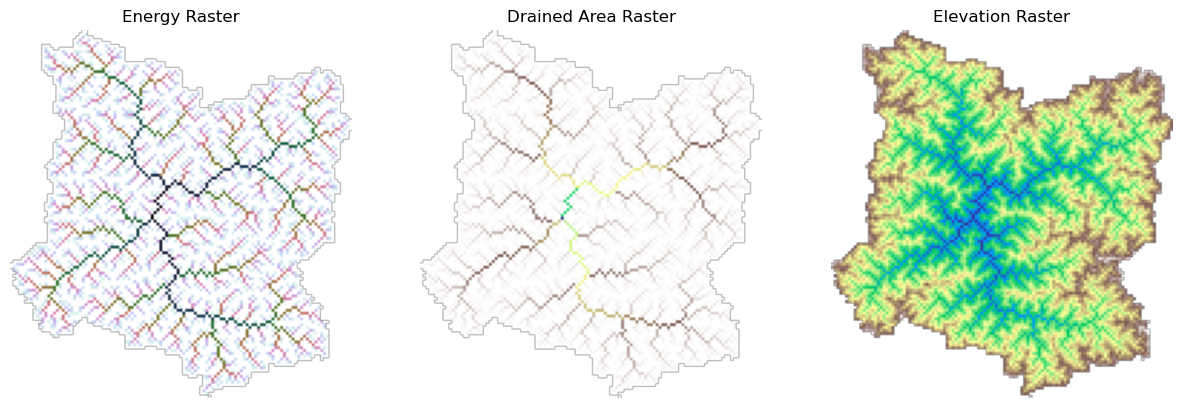

In [7]:
# set wrap=True to set periodic boundary conditions
ocn = po.OCN.from_net_type("H", (100, 100), resolution=100.0, wrap=True, random_state=42, verbosity=1)
ocn.fit()

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
po.plotting.plot_ocn_raster(ocn, attribute="energy", ax=axs[0], cmap="cubehelix_r", norm=mpl.colors.LogNorm())
axs[0].set_title("Energy Raster")
po.plotting.plot_ocn_raster(ocn, attribute="drained_area", ax=axs[1], cmap="terrain_r", norm=mpl.colors.PowerNorm(gamma=0.5))
axs[1].set_title("Drained Area Raster")
po.plotting.plot_ocn_raster(ocn, attribute="elevation", ax=axs[2])
axs[2].set_title("Elevation Raster")
for ax in axs:
    ax.axis('off')